# Spectroperfectionism in a Nutshell

The "Spectroperfectionism" algorithm models the spectral flux that would produce
observed noisy pixel-level raw data using the full 2D "point spread function" (PSF) that
describes how flux from spectra is projected onto the raw 2D data.  The algorithm
was originally described in Bolton & Schlegel (2009) (https://arxiv.org/abs/0911.2689)

## Spectroperfectionism math

Raw data pixels $p$ are modeled as a linear algebra projection $A$ of input spectral flux $f$ such that

$$p = Af + \mathrm{noise}$$

This can be solved using the "normal equations"

$$A^T W p = (A^T W A) f$$

where $A^T$ is the transpose of $A$ and $W = \mathrm{diag}(1/\sigma)$ is a diagonal weights matrix constructed from the estimated pixel noise $\sigma$.

The quanitity $A^T W A = C^{-1}$ is the inverse covariance matrix of $f$, which in general has off-diagonal covariance,
*i.e.* the elements of $f$ are correlated.  These can be decorrelated via a tranformation $R$ on both $C$ and $f$:

$$\tilde C = R C R^T$$
$$\tilde f = R f$$

Spectroperfectionism includes a prescription for calculating the "resolution matrix" $R$ that is the 1D equivalent of the 2D PSF that blurs the input spectra by the detector resolution.  This involves an eigen-decomposition of $C^{-1}$, both to calculate $R$ and to invert $C^{-1} \rightarrow C$ as part of calculating $\tilde C = R C R^T$.

The final outputs are:

  * Resolution convolved flux $\tilde f$ which is by construction uncorrelated between wavelengths
  * The squared uncertainties $\sigma_\lambda^2$ which are the diagonals of $\tilde C$ (off-diagonal elements are 0)
  * The resolution matrix $R$ that was used to decorrelated that data and which can be used to compare a
    high resolution model spectrum $m$ to the resolution convolved extract spectra $\tilde f$ via $R m$.  e.g. as a $\chi^2$:
  
$$
\chi^2_{\mathrm{1D}} = \sum_{\mathrm{wavelengths}~\lambda} \left( {\tilde{f} - (R m)_\lambda \over \sigma_\lambda}\right)^2
$$

<!--
If you have a model $m$ of the input flux, you can construct a $\chi^2$ in 2D pixel space:

$$\chi^2_{\mathrm{2D}} = \sum_{\mathrm{pixels}~i} \left( {p_i - (Am)_i \over \sigma_i}\right)^2$$

The outputs of spectroperfectionism are such that the following 1D $\chi^2$ is mathematically equivalent

$$\chi^2_{\mathrm{1D}} = \sum_{\mathrm{wavelengths}~\lambda} \left( {{\tilde{f} - (R m)_\lambda} \over {\sigma_\lambda}}\right)^2$$
-->

## Algorithmic steps

* Construct $A$ (special function evaluation to calculate the elements of $A$)
* Construct $C^{-1} = A^T W A$ and $A^T W p$ (sparse matrix-matrix and matrix-vector multiplication)
* Solve $A^T W p = (A^T W A) f$ for $f$ (sparse linear algebra solver, e.g. `scipy.sparse.linalg.spsolve`)
* Eigen-decompose $C^{-1}$ into eigenvalues $u$ and eigenvectors $v$ (currently using dense `numpy.linalg.eigh`)
* Construct sparse $R$ and diagonal $C$ using $u$ and $v$
  (dense matrix-matrix and matrix-vector multiplication resulting in sparse outputs)
* Construct final $\tilde f = Rf$ and $\tilde C = R C R^T$ (sparse matrix-matrix and matrix-vector multiplication)

## Example code

This uses the `specter.psf` code to calculate the elements of $A$; the rest of the math has been
pulled out of specter for this example.

In [1]:
import numpy as np
import specter.psf
import scipy.sparse
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#- Load a PSF model (included here)
psf = specter.psf.load_psf('psf.fits')

In [3]:
#- Generate some fake input data
wavemin, wavemax = 6000., 6050.
wavelengths = np.arange(wavemin, wavemax)
nwave = len(wavelengths)
nspec = 5
influx = np.zeros((nspec, nwave))
for i in range(nspec):
    influx[i, 5*(i+1)] = 100*(i+1)

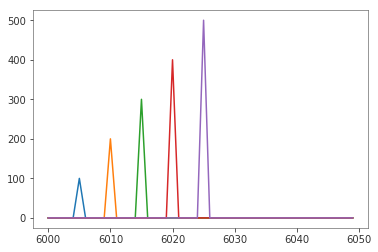

In [4]:
for i in range(nspec):
    plot(wavelengths, influx[i])

### Get the projection matrix $A$ using the PSF model

In [5]:
specrange = (0,nspec)
xyrange = xmin, xmax, ymin, ymax = psf.xyrange(specrange, wavelengths)
A = psf.projection_matrix(specrange, wavelengths, xyrange)

In [6]:
print('A.shape = {}'.format(A.shape))
print('Non-zero fraction = {:.3f}'.format(A.nnz / (A.shape[0] * A.shape[1])))

A.shape = (6490, 250)
Non-zero fraction = 0.063


### Confirm the dimensions of $A$

In [7]:
ny = ymax-ymin
nx = xmax-xmin
A.shape[0] == ny*nx, A.shape[1] == nspec*nwave

(True, True)

Although $A$ is a 2D matrix for the purposes of linear algebra, it could be viewed
as a reshaping of a 4D matrix for how each (spectrum, wavelength) projects onto the 2D image (ny,nx)

In [8]:
A4 = A.toarray().reshape((ny, nx, nspec, nwave))

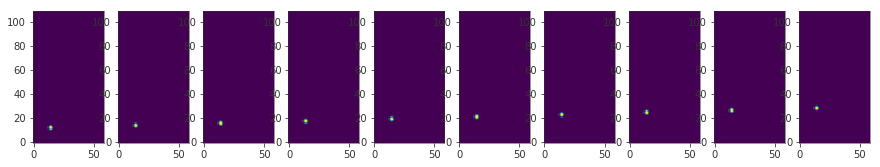

In [9]:
#- The same spectrum (0) at different wavelengths
figure(figsize=(15,5))
for iwave in range(10):
    subplot(1,10,iwave+1)
    imshow(A4[:,:,0,iwave])
    # xlim(0,20); ylim(0,20)

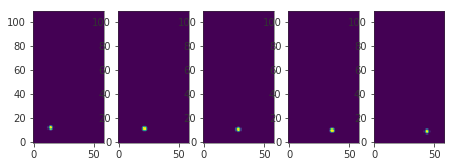

In [10]:
#- The same wavelength on different spectra
figure(figsize=(15,5))
for ispec in range(nspec):
    subplot(1,10,ispec+1)
    imshow(A4[:,:,ispec,0])

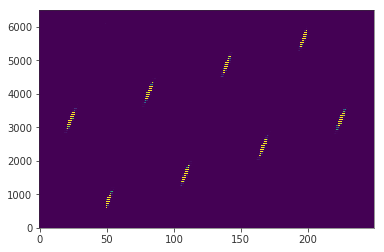

In [11]:
imshow(A.todense(), aspect='auto', vmax=0.01)

### Projecting flux onto images using $A$

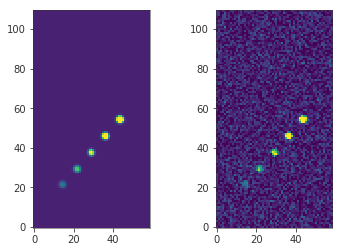

In [12]:
img = A.dot(influx.ravel()).reshape((ny, nx))
readnoise = 3.0
noisyimg = np.random.poisson(img) + np.random.normal(scale=readnoise, size=(ny,nx))

subplot(121)
imshow(img, vmin=-3, vmax=30)
subplot(122)
imshow(noisyimg, vmin=-3, vmax=30)

### Constructing $C^{-1} = A^T W A$ and $y = A^T W p$

In [13]:
imgweights = 1/(readnoise**2 + noisyimg.clip(0, 1e6))
npix = ny*nx
W = scipy.sparse.spdiags(data=imgweights.ravel(), diags=[0,], m=npix, n=npix)
iCov = A.T.dot(W.dot(A))
y = A.T.dot(W.dot(noisyimg.ravel()))

### Solving for $f$

In [14]:
f = scipy.sparse.linalg.spsolve(iCov, y).reshape(nspec, nwave)

Text(0.5,1,'Extracted flux')

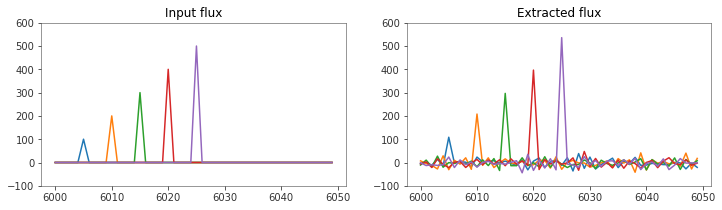

In [15]:
figure(figsize=(12,3))
subplot(121)
for i in range(nspec):
    plot(wavelengths, influx[i])

ylim(-100, 600)
title('Input flux')

subplot(122)
for i in range(nspec):
    plot(wavelengths, f[i])

ylim(-100, 600)
title('Extracted flux')

### Solving for $C$ and $R$

In [16]:
u, v = np.linalg.eigh(iCov.todense())
u = np.asarray(u)
v = np.asarray(v)

In [17]:
udiags = scipy.sparse.spdiags(1/u, 0, len(u), len(u))
Cov = v.dot( udiags.dot( v.T ))

In [18]:
#- confirm that C C^-1 = C^-1 C = I
assert np.allclose(Cov.dot(iCov.todense()), np.eye(Cov.shape[0]))
assert np.allclose(iCov.todense().dot(Cov), np.eye(Cov.shape[0]))

In [19]:
#- matrix square root QQ = C^-1 is used as intermediate for calculating R
d = scipy.sparse.spdiags(np.sqrt(u), 0, len(u), len(u))
Q = v.dot( d.dot( v.T ))
assert np.allclose(Q.dot(Q), iCov.todense())

In [20]:
norm_vector = np.sum(Q, axis=1)
R = np.outer(norm_vector**(-1), np.ones(norm_vector.size)) * Q

Text(0.5,1,'log(abs(C))')

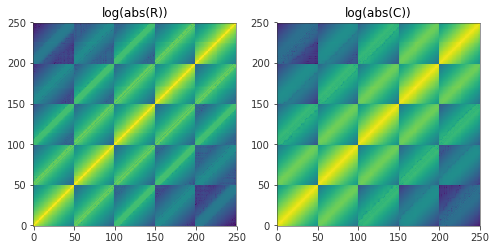

In [21]:
figure(figsize=(8,4))
subplot(121)
imshow(np.log(np.abs(R)))
title('log(abs(R))')

subplot(122)
imshow(np.log(np.abs(Cov)))
title('log(abs(C))')

### Construct $\tilde C$ and $\tilde f$

We'll call these `Cx` and `fx` in the code

In [22]:
Cx = R.dot(Cov.dot(R.T))
fx = R.dot(f.ravel()).reshape(f.shape)

The variances of $\tilde f$ are the diagonal elements of $\tilde C$ (off diagonal elements are ~0)

In [23]:
varfx = np.diagonal(Cx)

#### Plotting extracted fluxes $f$ and $\tilde f$

Text(0.5,1,'Resolution convolved decorrelated flux')

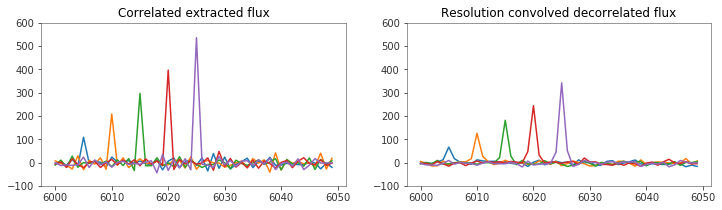

In [24]:
figure(figsize=(12,3))
subplot(121)
for i in range(nspec):
    plot(wavelengths, f[i])

ylim(-100, 600)
title('Correlated extracted flux')

subplot(122)
for i in range(nspec):
    plot(wavelengths, fx[i])

ylim(-100, 600)
title('Resolution convolved decorrelated flux')

$\tilde f$ (right) has lost resolution compared to $f$ (left) but doesn't have the correlated ringing

#### Plotting covariances $C$ and $\tilde C$

Text(0.5,1,'log(abs(Cx))')

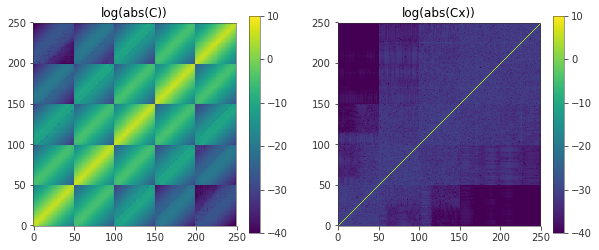

In [25]:
figure(figsize=(10,4))
subplot(121)
imshow(np.log(np.abs(Cov)), vmin=-40, vmax=10)
colorbar()
title('log(abs(C))')

subplot(122)
imshow(np.log(np.abs(Cx)), vmin=-40, vmax=10)
colorbar()
title('log(abs(Cx))')

The covariance of $f$ is $C$, which has off-diagonal covariance (left),
while the covariance of $\tilde f$ is $\tilde C$, which only has machine roundoff off-diagonal elements (right)

## Putting it all together

In [26]:
def extract(noisyimg, imgweights, A):
    '''
    Perform spectroperfectionism extractions returning flux, varflux, R
    
    Inputs:
        noisyimage[ny,nx] : input image
        imgweights[ny,nx] : inverse variance weights of input image
        A[ny*nx, nspec*nwave] : projection matrix for p = A f
    
    Returns (f, vf, R) where
      * f[nspec*nwave] = extracted resolution convolved flux
      * vf[nspec*nwave] = variance on f (not inverse variance...)
      * R[nspec*nwave, nspec*nwave] = dense resolution matrix
      
    TODO:
      * convert R into per-spectrum sparse matrix
      * add options for only decorrelating within a spectrum instead of across spectra
      * add options for doing 2D vs. 3D vs. 4D dimension wrangling
    '''
    ny, nx = noisyimg.shape
    npix = ny*nx

    #- Set up the equation to solve (B&S eq 4)
    W = scipy.sparse.spdiags(data=imgweights.ravel(), diags=[0,], m=npix, n=npix)
    iCov = A.T.dot(W.dot(A))
    y = A.T.dot(W.dot(noisyimg.ravel()))

    #- Solve f (B&S eq 4)
    f = scipy.sparse.linalg.spsolve(iCov, y).reshape(nspec, nwave)

    #- Eigen-decompose iCov to assist in upcoming steps
    u, v = np.linalg.eigh(iCov.todense())
    u = np.asarray(u)
    v = np.asarray(v)

    #- Calculate C^-1 = QQ (B&S eq 10)
    d = scipy.sparse.spdiags(np.sqrt(u), 0, len(u), len(u))
    Q = v.dot( d.dot( v.T ))
    
    #- normalization vector (B&S eq 11)
    norm_vector = np.sum(Q, axis=1)
    
    #- Resolution matrix (B&S eq 12)
    R = np.outer(norm_vector**(-1), np.ones(norm_vector.size)) * Q

    #- Decorrelated covariance matrix (B&S eq 13-15)
    udiags = scipy.sparse.spdiags(1/u, 0, len(u), len(u))
    Cov = v.dot( udiags.dot( v.T ))
    Cx = R.dot(Cov.dot(R.T))
    
    #- Decorrelated flux (B&S eq 16)
    fx = R.dot(f.ravel()).reshape(f.shape)
    
    #- Variance on f (B&S eq 13)
    varfx = np.diagonal(Cx)
    
    return fx, varfx, R

In [27]:
%timeit A = psf.projection_matrix(specrange, wavelengths, xyrange)

33.2 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit fx, varfx, R = extract(noisyimg, imgweights, A)

23.1 ms ± 781 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Details, details...

The $R$ calculated here decorrelates both across wavelengths within the same spectrum, and across spectra.
What we really want is decorrelating within a spectrum but not across spectra.  That is implemented in
`specter.extract.ex2d.ex2d_patch` when `ndecorr=False`, which involves a messier calculation of $R$.
In practice we will need to support both options.

## In Progress: Calculating the projection matrix $A$

In the above, we used the specter PSF model to calculate $A$ using `psf.projection_matrix`.
Let's dig deeper into the math of the PSF model.

The core of the PSF is modeled as Gauss Hermite polynomials integrated over each pixel:

$$
PSF_{\mathrm{core}}(x,y) = \int_{\mathrm{pixel}} G(x/\sigma_x)~G(y/\sigma_y)~\sum_{i,j}~C_{ij}~He_i(x/\sigma_x)~He_j(y/\sigma_y) dx dy
$$

where $G(z) = \exp(-0.5 z^2) / \sqrt{2\pi}$ and $He_n(z)$ is the $n$th degree probabilist's Hermite polynomial.

`specter.psf.gausshermite.pgh` (pixelated Gauss-Hermite) uses a recurrence relationship to efficiently evaulate the integral over pixels, though I haven't re-derived the exact implementation from recurrence relationships that I know so I haven't documented it here yet.

This is added to a PSF tail which is evaluated at pixel centers (i.e. not integrated)
$$
PSF_{\mathrm{tail}}(x,y) = A {r^2 \over (t_c^2 + r^2)^{(1+t_i/2)}}
$$
where $r^2 = (x/\sigma_{tx})^2 + (y/\sigma_{ty})^2$

The parameters themselves ($\sigma_x$, $\sigma_y$, $C_{ij}$, etc.) are modeled as Legendre polynomials as a function of wavelength (currently degree 7 = 8 Legendre coefficients per fiber per parameter).

We currently use degree 8 GH polynomials, *i.e.* $(8+1) \times (8+1) = 81$ $C_{ij}$ coefficients, plus another 9 parameters ($x$, $y$, $\sigma_x$, $\sigma_y$, $\sigma_{tx}$, $\sigma_{ty}$, $A$, $t_c$, $t_i$), each of which must be evaluated for 500 fibers at ~2800 wavelengths.  i.e. there are $90 \times 500 = 45000$ Legendre polynomials of degree 7, which must be evaluated at the same ~2800 wavelengths.



### Steps to calculate $A$

* Evaluate Legendre polynomials to derive the parameters $x$, $y$, $\sigma_x$, $\sigma_y$, $C_{ij}$ etc. (90 of them for 500 fibers at ~2800 wavelengths)
  * 90 &times; 500 &times; 2800 &times; 8 = 1 GB of memory
* Use those parameters to evaluate the PSF spots (500 fibers x 2800 wavelengths = 1.4M spots of size 8x14 pixels each)
  * 1.4e6 &times; 8 &times; 14 &times; 8 = 1.25 GB of memory
* Place those spots into the correct locations in $A$ (tedious)

### Evaluating Legendre Polynomials

In [29]:
#- Read the PSF parameters from a PSF file without using specter
from astropy.table import Table
params = Table.read('psf.fits')

In [30]:
#- Create a wavelength grid in 0.8 Angstrom steps
wavemin, wavemax = params['WAVEMIN'][0], params['WAVEMAX'][0]
ww = np.arange(wavemin, wavemax, 0.8)
nw = len(ww)

In [31]:
#- Make sure we understand the shape of the coeff array
assert params.meta['LEGDEG'] == params['COEFF'].shape[-1]-1

In [33]:
#- convert wavelengths ww -> [-1,1] for Legendre evaluation
wx = (ww - wavemin) * (2.0 / (wavemax - wavemin)) - 1.0

#- Get the Vandermonde matrix for rapid evaluation of N>>1 polynomials at the same wavelengths
%time L = np.polynomial.legendre.legvander(wx, params.meta['LEGDEG'])
print('L.shape = {}'.format(L.shape))

CPU times: user 399 µs, sys: 206 µs, total: 605 µs
Wall time: 392 µs
L.shape = (2802, 8)


In [34]:
#- Evaluate the coefficients for all spectra at all wavelengths for all parameters

# TODO: I almost certainly don't have the order of my transposes and reshapes
# correct here, but it should be doing the correct number of operations
# to evaluate a cache of 500*2802*91 = 127M parameters in O(1) second (!)

ca = params['COEFF']

#- for less memory intensive testing
# ca = ca[:,0:10,:]

nparam, nspec, ndeg = ca.shape
cb = ca.T.reshape( (ndeg, nspec*nparam) )
%time coeff = L.dot(cb).reshape((nw, nparam, nspec)).T

print('nparam = {}'.format(nparam))
print('nspec = {}'.format(nspec))
print('ndeg = {}'.format(ndeg))
print('Input Legendre coefficients shape = {}'.format(ca.shape))
print('Intermediate cb shape = {}'.format(cb.shape))
print('Output coefficient cache shape = {}'.format(coeff.shape))


CPU times: user 346 ms, sys: 235 ms, total: 581 ms
Wall time: 585 ms
nparam = 91
nspec = 500
ndeg = 8
Input Legendre coefficients shape = (91, 500, 8)
Intermediate cb shape = (8, 45500)
Output coefficient cache shape = (500, 91, 2802)


### Evaluating the PSF spots

I haven't worked out the details, but we should aim for something similar to the above for the
Legendre polynomial evaluations -- evaluating the PSF spot components for all fibers at all
wavelengths in a single vectorized call instead of evaluating Gauss Hermite polynomials in
`nspec*nwave` separate calls.